# Thermo-optic modulator with a doped silicon heater

In this example we investigate the modulation of a silicon waveguide with an embedded doped silicon p++ - p - p++ junction inspired by the design presented in [Chuyu Zhong, Hui Ma, Chunlei Sun, Maoliang Wei, Yuting Ye, Bo Tang, Peng Zhang, Ruonan Liu, Junying Li, Lan Li, and Hongtao Lin, "Fast thermo-optical modulators with doped-silicon heaters operating at 2 μm", Opt. Express 29, 23508-23516 (2021)](https://opg.optica.org/oe/fulltext.cfm?uri=oe-29-15-23508&id=453181). The primary modulation effect is due to heating occurring inside the waveguide as a potential difference is applied across the p++ - p - p++ junction. For calculation of current flowing through the device we use our [Charge solver](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.SemiconductorMedium.html#tidy3d.SemiconductorMedium). Subsequent heat distribution and waveguide mode analysis is done with Tidy3D's heat and mode solvers.

The sketch below highlights the geometric features of the considered waveguide:

<img src="img/doped_silicon_heater.png" alt="3D view of the modulator" width="500" />
<img src="img/ppp_junction.png" alt="Modulator Cross-Section"  width="500"/>

We begin by importing the required modules for this example.

In [1]:
import numpy as np
import tidy3d as td
import tidy3d.web as web
from matplotlib import pyplot as plt

Next, let's define some geometric properties of the waveguide as well as the doping. We define three doping regions within the Si waveguide with concentrations p++ - p - p++. The interface between the high doping concentration and low doping concentration is delimited by ``[-x_i, x_i]`` with $x=0$ being the center of the waveguide.

In [2]:
# modulator cross section parameters (µm)
w_core = 0.5
h_core = 0.34
h_slab = 0.1
h_side = 0.1
w_contact = 0.5
x_side = 2.25
x_total = 3
x_i = 1.75
h_contact = 0.05
# for the present setup this contact height is not relevant
# since the conductors are not included in the simulation

# modulator doping concentrations (1/cm^3)
conc_p = 3.5e17
conc_pp = 0.85e20

## Charge simulation


We will begin by creating a Charge simulation. To define a Charge simulation we will need to create at least one [`SemiconductorMedium`](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.SemiconductorMedium.html#tidy3d.SemiconductorMedium). For this type of medium we can define the doping distributions that will be applied to all structures that have this as their medium. 

Let's start, then, with creating the doping. One of the methods we have to create doping profiles in Tidy3d is by defining **doping boxes**. We'll be using [`ConstantDoping`](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.ConstantDoping.html#tidy3d.ConstantDoping). One thing to note is that these **doping boxes are additive**, i.e., if two donor doping boxes overlap the total concentration in the overlap region will be sum of these two overlapping doping boxes. The following cell demonstrates this concept.

In [3]:
acceptors = []

acceptors.append(
    td.ConstantDoping(
        center=[0, 0, 0], size=[2 * x_total, 2 * h_core, td.inf], concentration=conc_p
    )
)
acceptors.append(
    td.ConstantDoping.from_bounds(
        rmin=[-x_total, 0, -td.inf], rmax=[-x_i, h_side, td.inf], concentration=conc_pp - conc_p
    )
)
acceptors.append(
    td.ConstantDoping.from_bounds(
        rmin=[x_i, 0, -td.inf], rmax=[x_total, h_side, td.inf], concentration=conc_pp - conc_p
    )
)

We can use this doping in our semiconductor material

In [4]:
# let's define a material here for our Charge simulations
si_doped = td.MultiPhysicsMedium(
    optical=td.material_library["cSi"]["Li1993_293K"],
    charge=td.SemiconductorMedium(
        permittivity=11.1,
        N_c=2.86e19,
        N_v=3.1e19,
        E_g=1.11,
        mobility_n=td.ConstantMobilityModel(mu=400),
        mobility_p=td.ConstantMobilityModel(mu=200),
        R=[td.ShockleyReedHallRecombination(tau_n=1e-8, tau_p=1e-8)],
        N_a=acceptors,
    ),
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

### Charge structures
Now that we have our semiconductor material let's create some structures that will use it.

In [5]:
core = td.Structure(
    geometry=td.Box(center=(0, h_core / 2, 0), size=(w_core, h_core, td.inf)),
    medium=si_doped,
    name="core",
)

left_slab = td.Structure(
    geometry=td.Box(
        center=(-(x_side + w_core / 2) / 2, h_slab / 2, 0),
        size=(x_side - w_core / 2, h_slab, td.inf),
    ),
    medium=si_doped,
    name="left_slab",
)

left_side = td.Structure(
    geometry=td.Box(
        center=(-(x_side + x_total) / 2, h_side / 2, 0), size=(x_total - x_side, h_side, td.inf)
    ),
    medium=si_doped,
    name="left_side",
)

right_slab = td.Structure(
    geometry=td.Box(
        center=((x_side + w_core / 2) / 2, h_slab / 2, 0),
        size=(x_side - w_core / 2, h_slab, td.inf),
    ),
    medium=si_doped,
    name="right_slab",
)

right_side = td.Structure(
    geometry=td.Box(
        center=((x_side + x_total) / 2, h_side / 2, 0), size=(x_total - x_side, h_side, td.inf)
    ),
    medium=si_doped,
    name="right_side",
)


For ease in defining boundary conditions we define here some auxiliary structures made up of a conductive medium defined with [`ChargeConductorMedium`](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.ChargeConductorMedium.html#tidy3d.ChargeConductorMedium) 

In [6]:
contact_medium = td.MultiPhysicsMedium(
    charge=td.ChargeConductorMedium(conductivity=1), name="contact"
)

contact_p = td.Structure(
    geometry=td.Box(
        center=(-x_total + w_contact / 2, h_side + h_contact / 2, 0),
        size=(w_contact, h_contact, td.inf),
    ),
    medium=contact_medium,
    name="contact_p",
)

contact_n = td.Structure(
    geometry=td.Box(
        center=(x_total - w_contact / 2, h_side + h_contact / 2, 0),
        size=(w_contact, h_contact, td.inf),
    ),
    medium=contact_medium,
    name="contact_n",
)

### Charge scene
We can now put those structures together into a scene and explore what it looks like

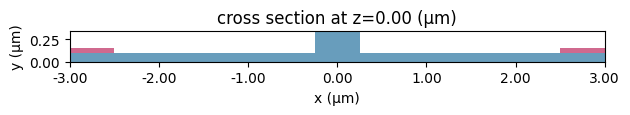

In [7]:
# create a scene with the previous structures
Si_structures = [left_side, left_slab, core, right_slab, right_side]

all_structures = Si_structures + [contact_p, contact_n]

scene_charge = td.Scene(
    medium=air,
    structures=all_structures,
)

scene_charge.plot(z=0)
plt.show()

Let's also inspect the doping profiles and make sure it is what we were expecting.

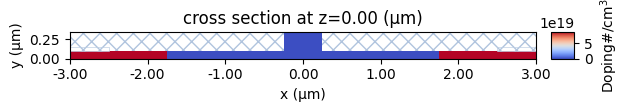

In [8]:
scene_charge.plot_structures_property(z=0, property="doping")
plt.show()

### Charge boundary conditions
Since we're interested in the response of the system for different applied voltages we'll need to solve the charge problem at each of these voltages. In Charge this can readily be done since the [`VoltageBC`](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.VoltageBC.html#tidy3d.VoltageBC) can accept an array of voltages as source through [`DCVoltageSource`](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.DCVoltageSource.html#tidy3d.DCVoltageSource). A parameter scan will be run and the returned data will have the provided voltage values as a separate dimension.

Let's define forward bias values up to 5 V with a step of 0.5 V.

In [9]:
# create BCs
voltages = list(np.arange(0.0, 5.0, 0.5))

bc_v1 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=voltages)),
    placement=td.StructureBoundary(structure=contact_p.name),
)

bc_v2 = td.HeatChargeBoundarySpec(
    condition=td.VoltageBC(source=td.DCVoltageSource(voltage=0)),
    placement=td.StructureBoundary(structure=contact_n.name),
)

boundary_conditions = [bc_v1, bc_v2]

### Charge monitors
Since we're interested in obtaining the free carrier distribution we'll add a [`SteadyFreeCarrierMonitor`](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.SteadyFreeCarrierMonitor.html#tidy3d.SteadyFreeCarrierMonitor) to our Charge simulation. For visualization purposes we will also include a potential monitor, i.e., [`SteadyPotentialMonitor`](https://docs.flexcompute.com/projects/tidy3d/en/v2.8.0rc2/api/_autosummary/tidy3d.SteadyPotentialMonitor.html#tidy3d.SteadyPotentialMonitor)

Note that the below monitor has been defined in the plane.

In [10]:
charge_mnt = td.SteadyFreeCarrierMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    name="charge_mnt",
    unstructured=True,
)

potential_mnt = td.SteadyPotentialMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    name="potential_mnt",
    unstructured=True,
)
charge_monitors = [charge_mnt, potential_mnt]

### Charge simulation object
When running Charge, we need to define the type of Charge simulation and some convergence settings. In the current case we set an relative tolerance of $1\cdot 10^{-10}$ and an absolute tolerance of $5\cdot 10^{10}$. The absolute tolerance may seem big though one should notice we have variables (electrons/holes) that take on values many orders of magnitude larger than the tolerance ($\approx 10^{20}$).

In the current case, we are going to run an isothermal DC case which we can define the simulation with `IsothermalSteadyChargeDCAnalysis`. In DC mode we can set the parameter `convergence_dv` which tells the solver to limit the size of the sweep, i.e., if we need to solve for a bias of 0 and 0.5 and we set `convergence_dv=0.1`, it will force the solver to go between 0 and 0.5 at intervals of 0.1.

We'll use a spatial resolution of $0.005\mu m$.

In [11]:
convergence_settings = td.ChargeToleranceSpec(rel_tol=1e-10, abs_tol=1e10, max_iters=400)

analysis_type = td.IsothermalSteadyChargeDCAnalysis(
    temperature=300, tolerance_settings=convergence_settings, convergence_dv=0.5
)

res = 0.005
mesh = td.UniformUnstructuredGrid(dl=res, relative_min_dl=0)

We now have all the required elements to define a Charge simulation object. Note that the simulation has 0 size in the $z$ direction. With this, we'll make sure that the simulation is 2D even if the structures themselves are not.

We will see a warning about structures with bounds that extend exactly to the simulation edges. This message is important for optical simulations but can be safely disregarded for Charge simulations.

In [12]:
# build heat simulation object
charge_sim = td.HeatChargeSimulation.from_scene(
    scene=scene_charge,
    monitors=charge_monitors,
    analysis_spec=analysis_type,
    size=(2 * x_total, h_core, 0),
    center=(0, h_core / 2, 0),
    boundary_spec=boundary_conditions,
    grid_spec=mesh,
)

17:42:58 -03 WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 9 WARNING messages.                            


We can also plot here the simulation and some properties. In the properties plot, as well as the conductivity (which is invisible since the only conducting structures are the BC auxiliary ones) we can see the boundary conditions in blue and orange.

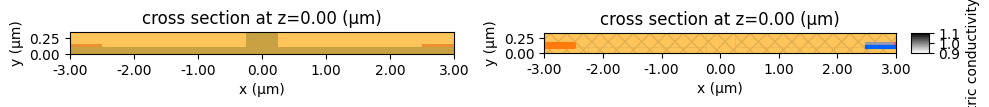

In [13]:
# plot simulation
fig, ax = plt.subplots(1, 2, figsize=(10, 15))
charge_sim.plot(z=0, ax=ax[0])
charge_sim.plot_property(z=0, property="electric_conductivity", ax=ax[1])
plt.tight_layout()
plt.show()

Now we can run the Charge simulation.

In [14]:
charge_data = web.run(charge_sim, task_name="modulator", path="charge_modulator.hdf5")

17:42:59 -03 Created task 'modulator' with task_id                              
             'hec-ffe318b9-e05e-45e3-b7d5-4388ec978c45' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

17:43:02 -03 Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

17:43:03 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:43:17 -03 status = preprocess

17:43:22 -03 starting up solver

             running solver

17:47:14 -03 status = success

Output()

17:47:29 -03 loading simulation from charge_modulator.hdf5

             WARNING: Structure at 'structures[0]' has bounds that extend       
             exactly to simulation edges. This can cause unexpected behavior. If
             intending to extend the structure to infinity along one dimension, 
             use td.inf as a size variable instead to make this explicit.       

             WARNING: Suppressed 9 WARNING messages.                            

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

### Solution visualization
We can explore the resulting hole density distribution as well as the resulting potential field at two different applied biases.

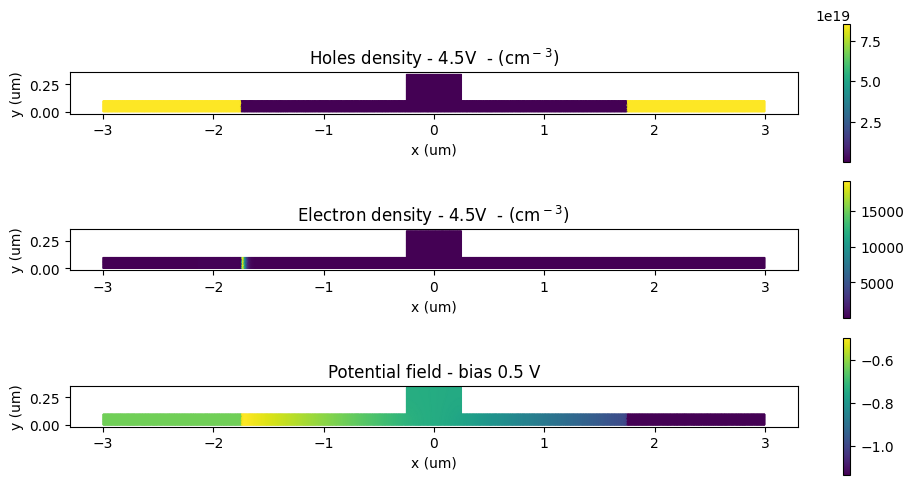

In [15]:
_, ax = plt.subplots(3, 1, figsize=(10, 5))

charge_data["charge_mnt"].holes.sel(z=0, voltage=voltages[-1]).plot(grid=False, ax=ax[0])
ax[0].set_title(f"Holes density - {voltages[-1]}V  - (cm$^-$$^3$)")

charge_data["charge_mnt"].electrons.sel(z=0, voltage=voltages[-1]).plot(grid=False, ax=ax[1])
ax[1].set_title(f"Electron density - {voltages[-1]}V  - (cm$^-$$^3$)")

for ind in range(2):
    ax[ind].set_xlabel("x (um)")
    ax[ind].set_ylabel("y (um)")

ax[2] = (
    charge_data["potential_mnt"].potential.sel(z=0, voltage=voltages[1]).plot(grid=False, ax=ax[2])
)
ax[2].set_title(f"Potential field - bias {voltages[1]:1.1f} V")
ax[2].set_xlabel("x (um)")
ax[2].set_ylabel("y (um)")

plt.tight_layout()
plt.show()


Whenever we run a charge simulation, Charge will output some device characteristics. These are not tight to any monitor but instead they are related to the whole device. For the current DC isothermal simulation we have the entry `steady_dc_current_voltage`. 

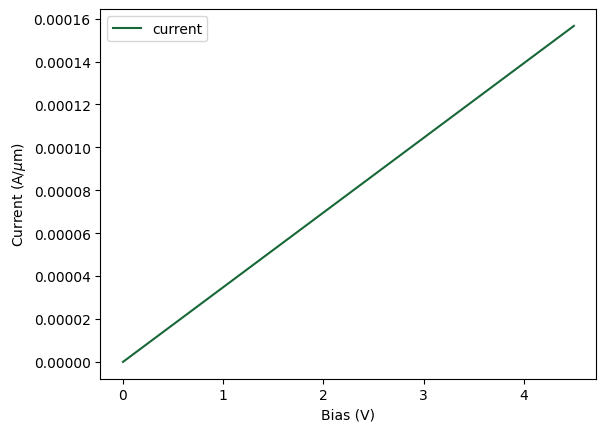

In [16]:
# let's plot the current as a function of the applied voltages
_, ax = plt.subplots(1, 1)
# since this is a 2D simulation the current is provided in A/um
currents = np.abs(charge_data.device_characteristics.steady_dc_current_voltage.values)
ax.plot(voltages, currents, label="current")
ax.set_xlabel("Bias (V)")
ax.set_ylabel(r"Current (A/$\mu$m)")
ax.legend()
plt.show()

## Heat and optics scene creation

Now that we have currents and carrier distributions for the waveguide we can start building the rest of the domain for heat and optics calculations. The waveguide is embedded in a silica cladding with the following dimensions:

In [17]:
# cladding dimensions (µm)
heat_sim_width = 20
h_cladding = 2.8  # thickness of cladding
h_box = 2  # thickness of buried oxide

# define center of the cladding so that the device sits 2um above
center_cladding = (0, h_cladding / 2, 0)
center_box = (0, -h_box / 2, 0)
center_heat_sim = (0, (h_cladding - h_box) / 2, 0)

Next we create the materials to be used. This is done through the functions `Medium()` and `PerturbationMedium()` of Tidy3D. The former is used for media with constant properties whereas we use the latter for materials with varying properties. In particular, the permittivity of Si will change with charge and temperature; and the permittivity of SiO2 will only vary with temperature.
It should be noted that a linear variation with temperature is considered, i.e., the temperature dependence of permittivity with temperature has been linearized at the given reference temperature.

For the Si charge-induced variation, we will use the empirical relationships presented in `M. Nedeljkovic, R. Soref and G. Z. Mashanovich, "Free-Carrier Electrorefraction and Electroabsorption Modulation Predictions for Silicon Over the 1–14- μm Infrared Wavelength Range," IEEE Photonics Journal, vol. 3, no. 6, pp. 1171-1180, Dec. 2011 `

In [18]:
Tref = 300
wvl_um = 2
freq0 = td.C_0 / wvl_um

# charge perturbation parameters
library_si = td.material_library["cSi"]["Li1993_293K"]
n_si, k_si = library_si.nk_model(frequency=freq0)


# Empiric relationships
ne_coeff = -1.91e-21
ne_pow = 0.992

nh_coeff = -2.28e-18
nh_pow = 0.841

k_factor = wvl_um * 1e-4 / 4 / np.pi  # factor for conversion from absorption coefficient into k

ke_coeff = k_factor * 3.22e-20
ke_pow = 1.149

kh_coeff = k_factor * 6.21e-20
kh_pow = 1.119

Ne_range = np.concatenate(([0], np.logspace(15, 20, 20)))
Nh_range = np.concatenate(([0], np.logspace(15, 20, 21)))

Ne_mesh, Nh_mesh = np.meshgrid(Ne_range, Nh_range, indexing="ij")

dn_mesh = ne_coeff * Ne_mesh**ne_pow + nh_coeff * Nh_mesh**nh_pow
dk_mesh = ke_coeff * Ne_mesh**ke_pow + kh_coeff * Nh_mesh**kh_pow

dn_data = td.ChargeDataArray(
    ne_coeff * Ne_mesh**ne_pow + nh_coeff * Nh_mesh**nh_pow,
    coords=dict(n=Ne_range, p=Nh_range),
)
dk_data = td.ChargeDataArray(
    ke_coeff * Ne_mesh**ke_pow + kh_coeff * Nh_mesh**kh_pow,
    coords=dict(n=Ne_range, p=Nh_range),
)

dn_si_charge = td.CustomChargePerturbation(perturbation_values=dn_data)
dk_si_charge = td.CustomChargePerturbation(perturbation_values=dk_data)


# Si thermal properties
Si_dndT = 1.76e-4  # Si thermo-optic coefficient dn/dT, 1/K

Si_k = 148e-6  # Si thermal conductivity, W / (um * K)
Si_s = 710  # Si specific heat capacity, J / (Kg * K)

dn_si_heat = td.LinearHeatPerturbation(coeff=Si_dndT, temperature_ref=Tref)


Si = td.PerturbationMedium.from_unperturbed(
    medium=td.Medium.from_nk(n=n_si, k=k_si, freq=freq0),
    perturbation_spec=td.IndexPerturbation(
        delta_n=td.ParameterPerturbation(
            charge=dn_si_charge,
            heat=dn_si_heat,
        ),
        delta_k=td.ParameterPerturbation(
            charge=dk_si_charge,
        ),
        freq=freq0,
    ),
    heat_spec=td.SolidSpec(
        conductivity=Si_k,
        capacity=Si_s,
    ),
    name="Si",
)

SiO2 thermal properties, extracted from [www.efunda.com](https://www.efunda.com/materials/elements/TC_Table.cfm?Element_ID=Si), [www.periodic-table.org](https://www.periodic-table.org/silicon-specific-heat/) and [www.azom.com](https://www.azom.com/properties.aspx?ArticleID=1114)

In [19]:
SiO2_n = 1.444  # SiO2 refraction index
SiO2_dndT = 1e-5  # SiO2 thermo-optic coefficient dn/dT, 1/K

SiO2_k = 1.38e-6  # SiO2 thermal conductivity, W/(um*K)
SiO2_s = 709  # SiO2 specific heat capacity, J / (Kg * K)\

SiO2 = td.PerturbationMedium.from_unperturbed(
    medium=td.Medium.from_nk(n=SiO2_n, k=0, freq=freq0),
    perturbation_spec=td.IndexPerturbation(
        delta_n=td.ParameterPerturbation(
            heat=td.LinearHeatPerturbation(coeff=SiO2_dndT, temperature_ref=Tref)
        ),
        freq=freq0,
    ),
    heat_spec=td.SolidSpec(
        conductivity=SiO2_k,
        capacity=SiO2_s,
    ),
    name="SiO2",
)

Note that since the permittivity of the material is a function of wave frequency, we require a reference wavelength. A reference temperature must also be given for the same reason.


We will reuse the structures generated for the Charge simulation here so only the cladding and substrate are left to be created. Note that, since we need to use perturbation materials for the silicon structures, we will update the material for those structures.

In [20]:
# create objects for heat simulation
cladding = td.Structure(
    geometry=td.Box(center=center_heat_sim, size=(td.inf, h_cladding + h_box, td.inf)),
    medium=SiO2,
    name="cladding",
)

substrate = td.Structure(
    geometry=td.Box(center=(0, -h_box - h_slab / 2, 0), size=(td.inf, h_slab, td.inf)),
    medium=Si,
    name="substrate",
)

In [21]:
# update silicon structures
for n, structure in enumerate(Si_structures):
    Si_structures[n] = structure.updated_copy(medium=Si)

Once we have the different structures we can create a scene and visualize it to make sure it's correct

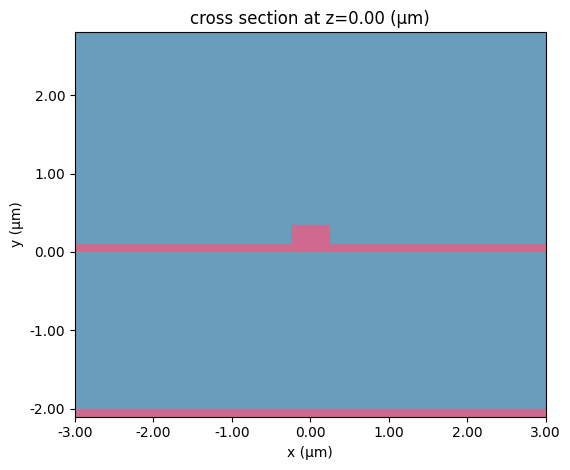

In [22]:
# create a scene with the previous structures
all_structures = [cladding, substrate] + Si_structures

scene = td.Scene(
    medium=air,
    structures=all_structures,
)

scene.plot(z=0)
plt.show()

## Heat simulation

Let's now start creating our heat simulation
### Boundary conditions
We next create thermal boundary conditions. 
We define two BCs: a temperature BC applied to the auxiliary Si structure; and convection boundary condition applied to the interface between the mediums air and SiO2.

In [23]:
## create heat simulation

bc_air = td.HeatChargeBoundarySpec(
    condition=td.ConvectionBC(ambient_temperature=300, transfer_coeff=10 * 1e-12),
    placement=td.MediumMediumInterface(mediums=[air.name, SiO2.name]),
)

bc_substrate = td.HeatChargeBoundarySpec(
    condition=td.TemperatureBC(temperature=300),
    placement=td.StructureStructureInterface(structures=[substrate.name, cladding.name]),
)

heat_bc = [bc_air, bc_substrate]

### Heat source
Next we create a heat source. 
The total input power to the system is the electric power, computed here as $P=V\cdot i$. Remember that the electric current computed previously comes from a 2D case and, therefore, it is current per unit length.

Additionally, the heat solver takes in volumetric sources applied over a defined volume. Since we will apply the heat source over the waveguide, we will divide the total power by the volume of the waveguide.

In [24]:
# add heat source
device_volume = (
    w_core * h_core  # core
    + 2.0 * (x_side - w_core / 2) * h_slab  # slabs
    + 2.0 * (x_total - x_side) * h_side  # sides
)

input_power = voltages[1] * currents[1]
print("Input power ", input_power * 1e3, " mW / um")

volumetric_heat = input_power / device_volume
print("Volumetric heat rate: ", volumetric_heat * 1e3, "mW / um^3")

heat_source = td.HeatSource(
    structures=[struct.name for struct in Si_structures], rate=volumetric_heat
)

Input power  0.008699502990878379  mW / um
Volumetric heat rate:  0.012082643042886636 mW / um^3


### Temperature monitor
Next, we define a temperature monitor.
We will be able to visualize the temperature field at the monitor.

In [25]:
# set a temperature monitor
temp_mnt = td.TemperatureMonitor(
    center=(0, 0, 0),
    size=(td.inf, td.inf, 0),
    name="temperature",
    unstructured=True,
    conformal=True,
)

The last element we need to define before we can run the heat simulation is the mesh which we build using Tidy3D function `DistanceUnstructuredGrid()`.
We will give this function 5 arguments:
- `dl_interface`defines the grid size near the interface.
- `dl_bulk`defines the grid size away from the interface.
- `distance_interface` defines the distance from the interface until which `dl_interface` will be enforced.
- `distance_bulk`defines the distance from the interface after which `dl_bulk` will be enforced.
- `non_refined_structures` allows us to specify structures which will not be refined.


In [26]:
dl_min = h_slab / 3
dl_max = 10 * dl_min
grid_spec = td.DistanceUnstructuredGrid(
    dl_interface=dl_min,
    dl_bulk=dl_max,
    distance_interface=dl_min,
    distance_bulk=4 * dl_max,
    non_refined_structures=[substrate.name],  # do not refine near wafer
)

### Heat simulation object
At this point we can finally create the heat simulation object as well as visualize it.

The red line indicates the convection BC whereas the yellow line depicts the temperature BC. The dotted area indicates where the heat source is being applied.

Note that we slightly expanded simulation in the y-direction to avoid structures' bounds to extend exactly to simulation edges and possibly causing an unexpected behavior.

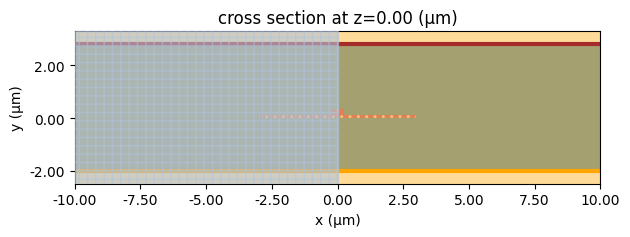

In [27]:
# build heat simulation object
heat_sim = td.HeatChargeSimulation.from_scene(
    scene=scene,
    center=center_heat_sim,
    size=(heat_sim_width, h_cladding + h_box + 1, 0),
    boundary_spec=heat_bc,
    sources=[heat_source],
    monitors=[temp_mnt],
    symmetry=(1, 0, 0),
    grid_spec=grid_spec,
)

heat_sim.plot(z=0)
plt.show()

The following runs the simulation.

In [28]:
# submit the job
job = web.Job(simulation=heat_sim, task_name="heat_sim_check_mesh")
heat_sim_data = job.run()

17:47:32 -03 Created task 'heat_sim_check_mesh' with task_id                    
             'hec-55fbda23-fa8a-4b10-9297-a25d9e6438ea' and task_type           
             'HEAT_CHARGE'.

             Tidy3D's HeatCharge solver is currently in the beta stage. Cost of 
             HeatCharge simulations is subject to change in the future.

Output()

17:47:34 -03 Maximum FlexCredit cost: 0.025. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

17:47:36 -03 status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

17:47:48 -03 status = preprocess

17:47:52 -03 starting up solver

17:47:53 -03 running solver

17:47:59 -03 status = success

Output()

17:48:03 -03 loading simulation from simulation_data.hdf5

             WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

### Temperature field visualization
Once we have the previous heat simulation we can check the mesh and the resulting temperature field. 

In the first plot we can check the thermal conductivity of the different materials. As it can be seen, silicon structures are much more conductive than the SiO2 cladding.

The last two pictures show the mesh and temperature field.

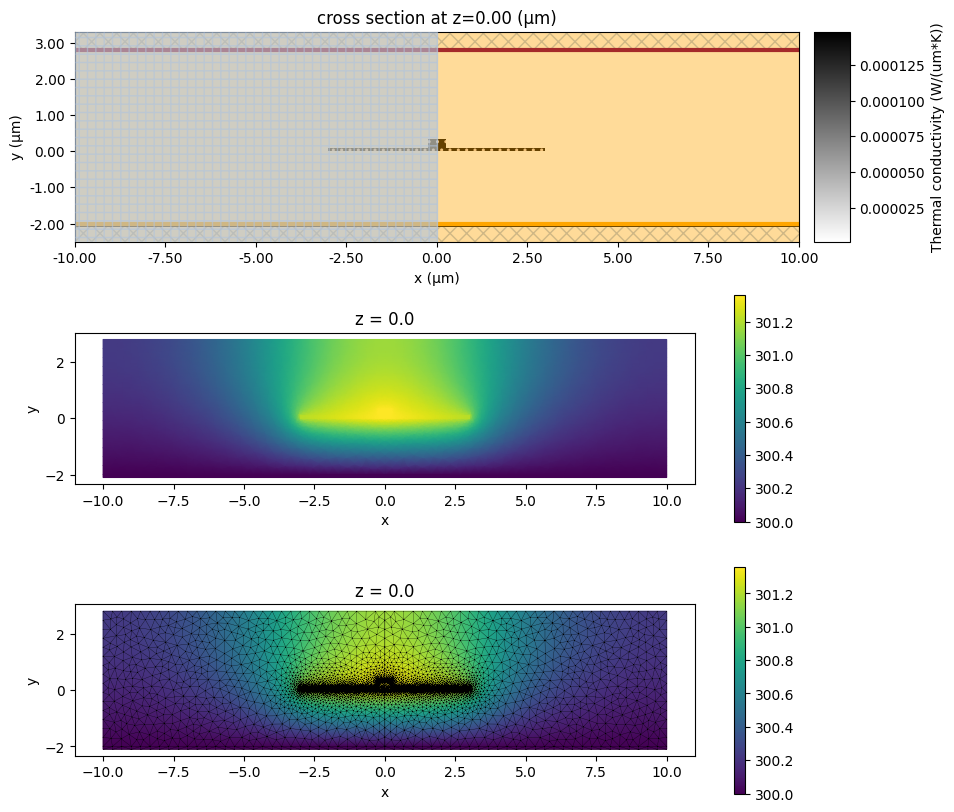

In [29]:
# let's check that the grid and temperature field make sense
_, ax = plt.subplots(3, 1, figsize=(10, 10))

# heat_sim.plot_heat_conductivity(z=0, ax=ax[0])
heat_sim.plot_property(z=0, ax=ax[0], property="heat_conductivity")
heat_sim_data["temperature"].temperature.plot(ax=ax[1], grid=False)
heat_sim_data["temperature"].temperature.plot(ax=ax[2])
plt.show()

Once we have made sure that the mesh and heat simulation parameters are acceptable, we can run the simulations for each voltage in the `voltages` array.
To do this we will first create a simulation object for each of the voltages:

In [30]:
# now let run it for a bunch of applied voltages
heat_simulations = {}
for n, (v, i) in enumerate(zip(voltages, currents)):
    input_power = v * i
    volumetric_heat = input_power / device_volume
    # update heat sources for each structure
    heat_source = td.HeatSource(
        structures=[struct.name for struct in Si_structures], rate=volumetric_heat
    )

    # update the simulation object
    sim_name = "thermal_case_" + str(n)
    heat_simulations[sim_name] = heat_sim.updated_copy(sources=[heat_source])

In [31]:
thermal_batch_data = web.Batch(simulations=heat_simulations, reduce_simulation=True).run()

Output()

17:48:09 -03 Started working on Batch containing 10 tasks.

17:48:21 -03 Maximum FlexCredit cost: 0.250 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

17:49:05 -03 Batch complete.

Output()

Once the heat simulations have finished we can visualize a couple of them to make sure they're good:

17:49:18 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:21 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

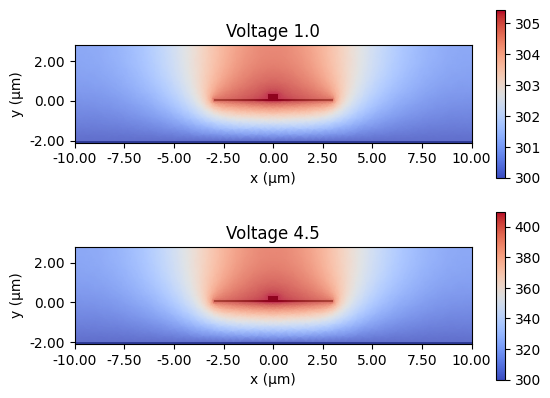

In [32]:
# plot first and last case
_, ax = plt.subplots(2, 1)
thermal_batch_data["thermal_case_2"].plot_field("temperature", ax=ax[0])
thermal_batch_data[f"thermal_case_{len(voltages) - 1}"].plot_field("temperature", ax=ax[1])
ax[0].set_title(f"Voltage {voltages[2]}")
ax[1].set_title(f"Voltage {voltages[-1]}")
plt.show()

## Combined Electric and Thermal Perturbations

Once we have run the heat simulations, we can apply the temperature fields obtained along with the free carrier distributions obtained previously to our optical simulations. 

As a first step we need to create a reference optics simulation:

In [33]:
grid_spec = td.GridSpec.auto(min_steps_per_wvl=50, wavelength=wvl_um)

optic_sim = td.Simulation.from_scene(
    scene=scene,
    center=center_heat_sim,
    size=(heat_sim_width, h_cladding + h_box + 1, wvl_um),
    run_time=1e-15,
    grid_spec=grid_spec,
)

Now that we have the reference optical simulation we can create a list of perturbed optical simulations. When passing charge and thermal fields to function `perturbed_mediums_copy()` one must make sure that the provided data fields are sampled on the same grid (structured or unstructured). Since in this example charge data and thermal data are coming from different grids, we first interpolate them onto a common grid, for which we select the Cartesian grid of the optic simulation.

In [34]:
perturbed_sims = []

target_grid = optic_sim.grid.boundaries

for n, v in enumerate(voltages):
    # deal first with temperature field
    name_thermal_data = "thermal_case_" + str(n)
    therm_data = thermal_batch_data[name_thermal_data]

    temp_interpolated = therm_data["temperature"].temperature.interp(
        x=target_grid.x, y=target_grid.y, z=0, fill_value=Tref
    )

    # now deal with charge distributions
    e_interpolated = (
        charge_data["charge_mnt"]
        .electrons.sel(voltage=v)
        .interp(x=target_grid.x, y=target_grid.y, z=0, fill_value=0)
    )
    h_interpolated = (
        charge_data["charge_mnt"]
        .holes.sel(voltage=v)
        .interp(x=target_grid.x, y=target_grid.y, z=0, fill_value=0)
    )
    # convert to SpatialDataArray
    coords_charge = {
        "x": e_interpolated.coords.get("x").values,
        "y": e_interpolated.coords.get("y").values,
        "z": e_interpolated.coords.get("z").values,
    }
    e_interpolated = td.SpatialDataArray(
        np.squeeze(e_interpolated.values, axis=3), coords=coords_charge
    )
    h_interpolated = td.SpatialDataArray(
        np.squeeze(h_interpolated.values, axis=3), coords=coords_charge
    )

    psim = optic_sim.perturbed_mediums_copy(
        electron_density=e_interpolated, hole_density=h_interpolated, temperature=temp_interpolated
    )

    perturbed_sims.append(psim)

17:49:23 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:27 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:30 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:33 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:37 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:40 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:43 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:46 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:49 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

17:49:53 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       


Now that we have created the perturbed simulation we can examine the change in permittivity due to these perturbations:

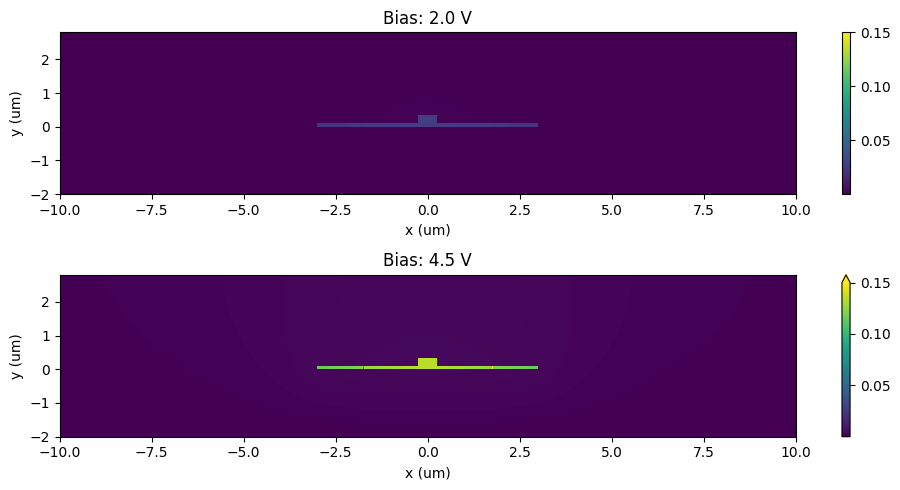

In [35]:
sample_region = td.Box(
    center=center_heat_sim,
    size=(heat_sim_width, h_cladding + h_box, 0),
)

eps_reference = perturbed_sims[0].epsilon(box=sample_region).isel(z=0, drop=True)

_, ax = plt.subplots(2, 1, figsize=(10, 5))
for ax_ind, n in enumerate([4, 9]):
    eps_doped = perturbed_sims[n].epsilon(box=sample_region).isel(z=0, drop=True)
    eps_doped = eps_doped.interp(x=eps_reference.x, y=eps_reference.y)
    eps_diff = np.abs(np.real(eps_doped - eps_reference))
    eps_diff.plot(x="x", ax=ax[ax_ind], vmax=0.15)

    ax[ax_ind].set_xlabel("x (um)")
    ax[ax_ind].set_ylabel("y (um)")
    ax[ax_ind].set_title(f"Bias: {voltages[n]:1.1f} V")

plt.tight_layout()
plt.show()

### Perturbation Mode Analysis

Instead of running a full wave simulation we will compute the modes of the waveguide. 
This is a smaller computation that will also highlight the influence of the temperature field over the refraction coefficient. 

We will compute the waveguide modes on a plane centered around the core section of the device:

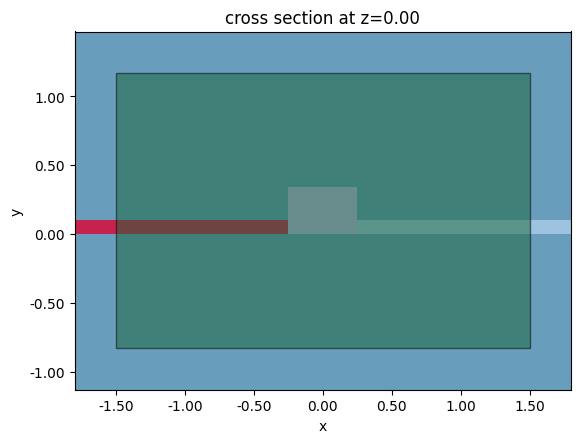

In [36]:
mode_plane = td.Box(center=(0, h_core / 2, 0), size=(3, 2, 0))

fig, ax = plt.subplots(1, 1)
perturbed_sims[0].plot(z=0, ax=ax)
mode_plane.plot(z=0, ax=ax, alpha=0.5)
plt.show()

The next few lines create the mode simulation objects for each of the temperature and carrier fields and submits the computation.

In [37]:
from tidy3d.plugins.mode import ModeSolver

mode_solvers = {}

for n, psim in enumerate(perturbed_sims):
    name = "psim" + str(n)
    mode_solvers[name] = ModeSolver(
        simulation=psim,
        plane=mode_plane,
        mode_spec=td.ModeSpec(num_modes=1, precision="double"),
        freqs=[freq0],
    )

Run all mode solver simulations in a batch.

In [38]:
mode_datas = web.Batch(simulations=mode_solvers, reduce_simulation=True).run()

Output()

17:50:04 -03 Started working on Batch containing 10 tasks.

17:50:15 -03 Maximum FlexCredit cost: 0.039 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

17:50:27 -03 Batch complete.

17:52:01 -03 WARNING: 10 files have already been downloaded and will be skipped.
             To forcibly overwrite existing files, invoke the load or download  
             function with `replace_existing=True`.                             

Output()

And finally we can see the combined effect of both thermal and carrier density on the refraction index.

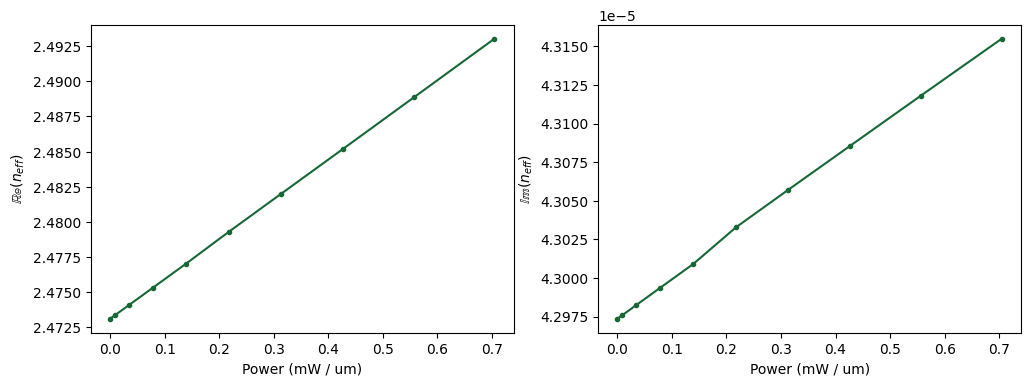

In [39]:
n_eff = np.array([md.n_complex.sel(f=freq0, mode_index=0) for md in mode_datas.values()])

power_mw = np.array(voltages) * np.array(currents) * 1e3

# plot n_eff
_, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(power_mw, np.real(n_eff), ".-")
ax[0].set_ylabel(r"$\mathbb{Re}(n_{eff}$)")
ax[0].set_xlabel("Power (mW / um)")

ax[1].plot(power_mw, np.imag(n_eff), ".-")
ax[1].set_ylabel(r"$\mathbb{Im}(n_{eff}$)")
ax[1].set_xlabel("Power (mW / um)")

plt.show()

Based on the computed refractive index we can now compute both phase shift and loss over a waveguide length of 100 µm as a function of the input (heating) power. As it can be seen, we'd need to apply a heating power of about $\approx 3.5mW$ in order to get a phase shift of $\pi$.

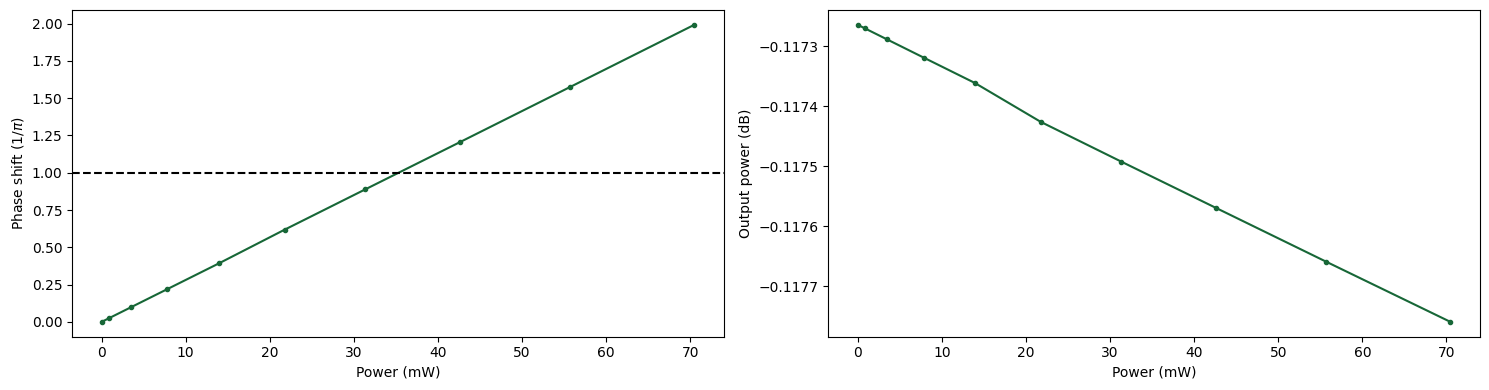

In [40]:
wvg_l = 100
phase_shift = 2 * np.pi / wvl_um * (np.real(n_eff) - np.real(n_eff[0])) * wvg_l
intensity = np.exp(-4 * np.pi * np.imag(n_eff) * wvg_l / wvl_um)
power_mw_per_100um = power_mw * 100

_, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(power_mw_per_100um, phase_shift / np.pi, ".-")
ax[0].axhline(y=1, color="k", linestyle="--")

ax[0].set_xlabel("Power (mW)")
ax[0].set_ylabel(r"Phase shift ($1/\pi$)")

ax[1].plot(power_mw_per_100um, 10 * np.log10(intensity), ".-")

ax[1].set_xlabel("Power (mW)")
ax[1].set_ylabel("Output power (dB)")

plt.tight_layout()
plt.show()